## Python notebook 
V nasledujúcom notebooku sú popísané Python metódy použité pre trénovanie SOM mapy a optimalizácie jej parametrov. Obsah notebooku je nasledujúci:
1. Import potrebných knižníc
2. Predspracovanie dát
3. Vytvorenie SOM mapy
4. Optimalizácia parametrov SOM mapy

# 1. Import potrebných knižníc

In [1]:
!pip install minisom
!pip install hyperopt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')

from IPython.display import Image, display
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd
import time
import pickle

from pylab import plot, axis, show, pcolor, colorbar, bone

from hyperopt import fmin, tpe, hp
from hyperopt import Trials, STATUS_OK

from mpl_toolkits.axes_grid1 import ImageGrid

# 2. Predspracovanie dát
Dáta načítame a predspracujeme do podoby vhodne pre model SOM.

In [3]:
#nacitam data na clustering
data = pickle.load(open('data/data_2014_11.pkl', 'rb'))
label = pickle.load(open('data/label_2014_11.pkl', 'rb'))
img_name = pickle.load(open('data/img_name.pkl', 'rb'))

In [4]:
data.shape

(13647, 150, 40, 3)

In [5]:
label.shape

(13647,)

In [6]:
som_data = (data - data.min()) / (data.max() - data.min())
som_data = som_data.reshape(13647, -1)
print(som_data[0])

[0.87058824 0.89019608 0.18431373 ... 0.         0.         0.        ]


In [7]:
target = label
som_data.shape

(13647, 18000)

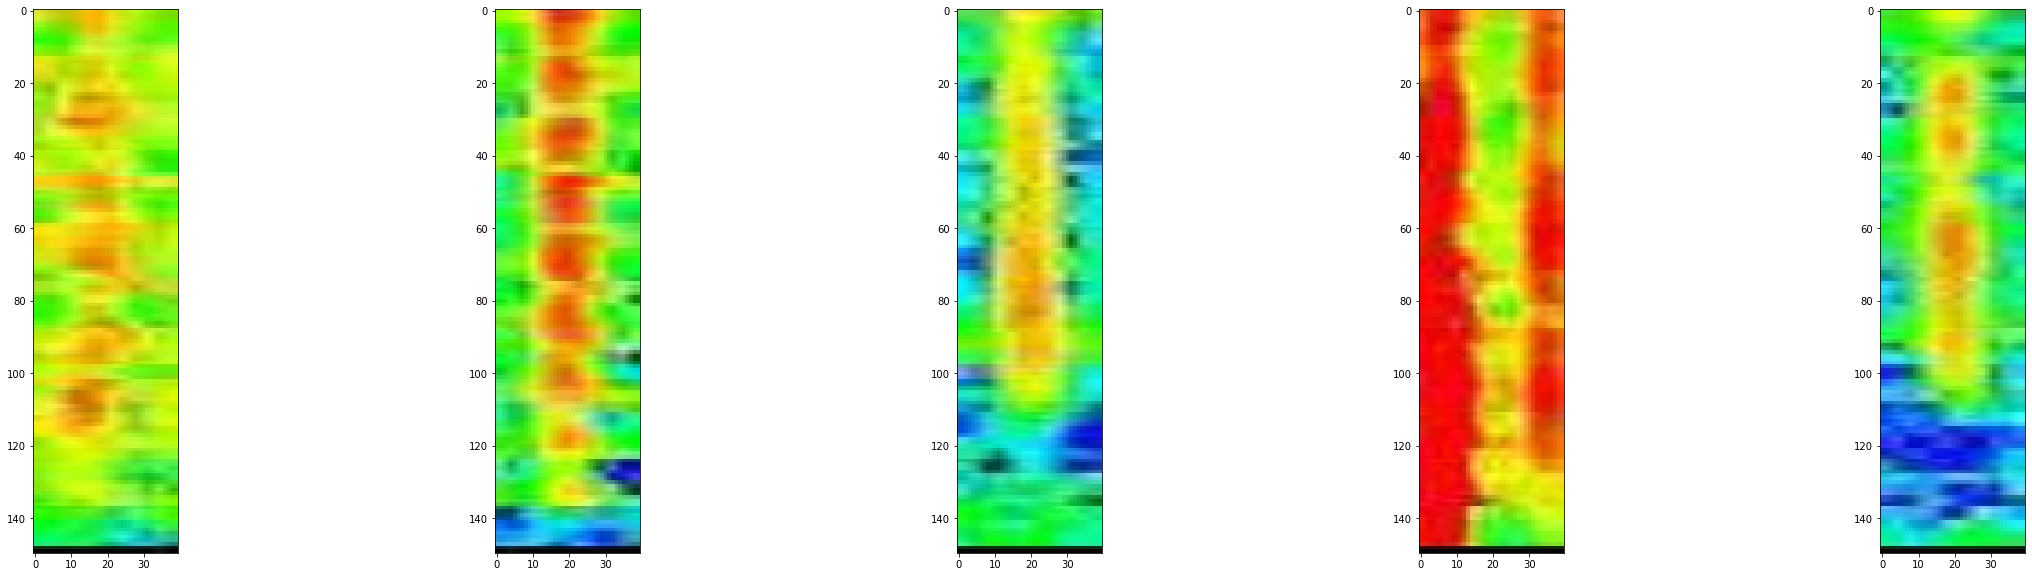

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(40, 10)
for i in range(5):
    ax[i].imshow(som_data[i].reshape(150, 40, 3))
plt.show()

# 3. Vytvorenie SOM mapy

Mapu natrénujeme s prednastavenými parametrami a vizualizujeme ju.

In [9]:
x = 5
y = 5
input_len = som_data.shape[1]
sigma = 1
learning_rate = 0.5
iterations = 100
seed = 42

In [10]:
data = som_data
som = MiniSom(x=x,
             y=y,
             input_len=input_len,
             sigma=sigma,
             learning_rate=learning_rate,
             random_seed = seed)
som.random_weights_init(data)

In [11]:
start_time = time.time()
som.train_random(data, iterations)
elapsed_time = time.time()-start_time
print(elapsed_time, " seconds")

0.19631171226501465  seconds


In [12]:
win_map = som.win_map(data)

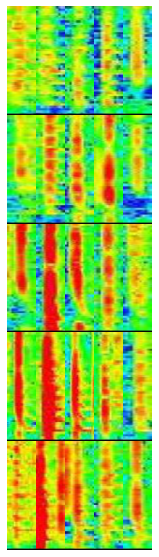

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_5_5_no_opti1.png')
#plt.show()

# 4. Optimalizácia parametrov SOM mapy

V prvom kroku optimalizujeme len parameter sigma a v druhom kroku optimalizujeme aj parameter learning_rate. Mapy s optimalizovanými parametrami natrénujeme a vizualizujeme.

In [14]:
def train_som(x, y, input_len, sigma, learning_rate, seed):
    #init
    som = MiniSom(x=x,
             y=y,
             input_len=input_len,
             sigma=sigma,
             learning_rate=learning_rate, random_seed = seed)
    som.random_weights_init(data)
    #training
    start_time = time.time()
    som.train_random(data, iterations)
    elapsed_time = time.time()-start_time
    print(elapsed_time, " seconds")
    return som

In [15]:
#sigma optimalizacia
start_time = time.time()
best = fmin(
    fn=lambda sig: MiniSom(x=x,
                          y=y,
                          input_len=input_len,
                          sigma=sig,
                          learning_rate=learning_rate,
                          random_seed = seed).quantization_error(data),
    space=hp.uniform("sig", 0.001, x/2.01),
    algo=tpe.suggest,
    max_evals=200)
elapsed_time = time.time()-start_time
print(elapsed_time, " seconds")
print(best)

100%|██████████| 200/200 [20:48<00:00,  6.24s/trial, best loss: 82.72795826601171]
1248.1421148777008  seconds
{'sig': 0.2003343831864928}


In [17]:
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}\nrandom_seed: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate,
                                                                        seed))

x: 5
y: 5
input_len: 18000
sigma: 0.2003343831864928
learning_rate: 0.5
random_seed: 42


In [18]:
som = train_som(x, y, input_len, sigma, learning_rate, seed)

0.20470666885375977  seconds


In [19]:
win_map = som.win_map(data)

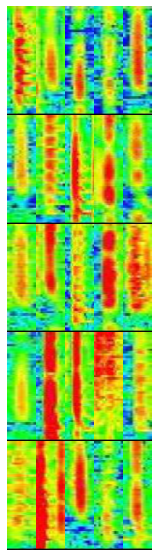

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_5_5_sig_opti.png')
#plt.show()

In [21]:
#optimalizacia sigma a learning rate
space = {
    'sig': hp.uniform('sig', 0.001, 5),
    'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x,
                  y=y,
                  input_len=input_len,
                  sigma=sig,
                  learning_rate=learning_rate, random_seed=seed).quantization_error(data)
    #print(val)
    return{'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials)

print('best: {}'.format(best))

for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

100%|██████████| 50/50 [05:12<00:00,  6.24s/trial, best loss: 82.72795826601171]
best: {'learning_rate': 4.017791221060744, 'sig': 3.0553534255989145}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 82.72795826601171, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [4.017791221060744], 'sig': [3.0553534255989145]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 2, 27, 12, 31, 21, 691000), 'refresh_time': datetime.datetime(2022, 2, 27, 12, 31, 27, 934000)}
1 {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 82.72795826601171, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'sig': [1]}, 'vals': {'learning_rate': [2.5425795051190665], 'sig': [1.4752940165464798]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime

In [22]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}\nrandom_seed: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate,
                                                                        seed))

x: 5
y: 5
input_len: 18000
sigma: 3.0553534255989145
learning_rate: 4.017791221060744
random_seed: 42


In [23]:
som = train_som(x, y, input_len, sigma, learning_rate, seed)

0.19098877906799316  seconds


In [25]:
win_map = som.win_map(data)

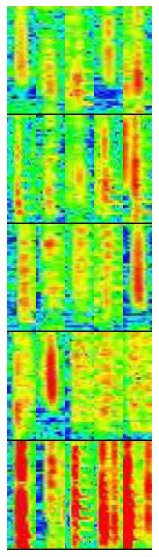

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_5_5_sigrate_opti.png')
#plt.show()